In [1]:
import sys
sys.path.insert(0, 'env')
sys.path.insert(0, 'lib')

import ccg
from agents import ARagent, A2Cagent, SkipAgent
import pandas as pd
import numpy as np
import copy
import random
import torch
import utils
seed = 12345644

np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)

cards = pd.read_csv('env/configue/cardsTable.csv')
cardsList = [ccg.Minion(i) for i in cards.values.tolist()]

cores = pd.read_csv('env/configue/cores.csv')
coreList = [ccg.Core(i) for i in cores.values.tolist()]

playersNum = 2
piles = [[ccg.Pile(cardsList, 10) for _ in range(4)] for _ in range(playersNum)]
cores = np.random.choice(coreList, 2)
decks = [ccg.Deck(cores[i], piles[i], i) for i in range(playersNum)]

In [2]:
session = ccg.Session(decks)

In [3]:
from __future__ import print_function
print(torch.__version__)

0.4.1


In [4]:
from trainer import Trainer
from agents import ARagent, A2Cagent
from nets import ActorNetwork, ValueNetwork
from replays import FlatReplay, PrioritizedReplay

actor = ActorNetwork(session.processObservation())
value = ValueNetwork(session.processObservation())
a2cAgent = A2Cagent(actor, value, 0, PrioritizedReplay(), epsilon = 0.5)
arAgent = ARagent(1)
skipAgent = SkipAgent(1)

trainer = Trainer(session, [a2cAgent, arAgent])

In [5]:
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

wins = dict()
wins[-1] = 0
wins[0] = 0
wins[1] = 0

health_adv_log = []
actions_num_log = []
turns_log = []
wins_log = []

actor_loss_log = []
value_loss_log = []

actor_loss_epoch = []
value_loss_epoch = []

print("Filling buffer")
for i in range(10):
    trainer.playGame(record = True, evaluate = False)
print("Buffer filled")       


Filling buffer


lib\agents.py:70: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_action = m(log_softmax_action)


Buffer filled


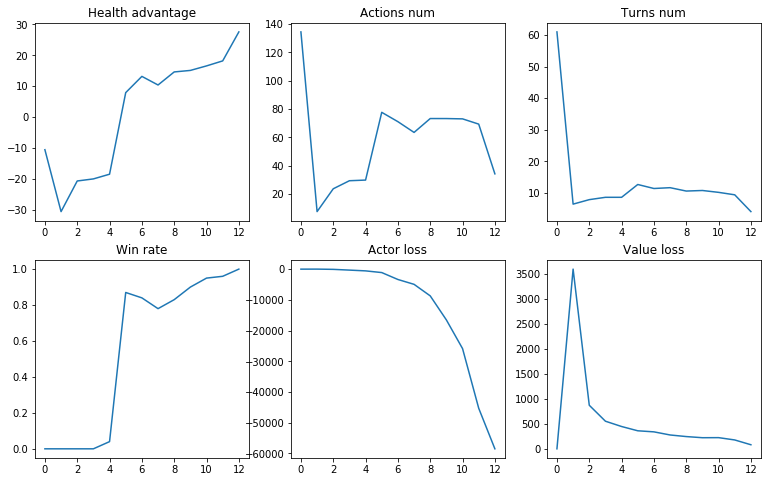

In [ ]:
for i in range(10000):
    for j in range(20):
        trainer.playSteps(10, replay_id = str(i)+" "+str(j))
    observation, _, _ = session.processNewStateInfo()
    winner = -1
    if(observation["loser"] != -1):
        winner = 1 - observation["loser"]
    wins[winner] += 1
    
    actor_loss, value_loss = trainer.train()[0]
    actor_loss_epoch.append(actor_loss)
    value_loss_epoch.append(value_loss)
    
    if(i % 50 == 0):
        eval_trainer = copy.deepcopy(trainer)
        clear_output()
        eval_games = 100
        mean_health_adv = 0
        mean_actions_num = 0
        mean_turns = 0
        mean_wins = 0
        for i in range(eval_games):
            adv, actions_num, turns, winner = eval_trainer.playGame(record = False, evaluate = True)
            mean_health_adv += adv[0]
            mean_actions_num += actions_num[0]
            mean_turns += turns
            mean_wins += winner[0]
            
        health_adv_log.append(mean_health_adv / eval_games)
        actions_num_log.append(mean_actions_num / eval_games)
        turns_log.append(mean_turns / eval_games)
        wins_log.append(mean_wins / eval_games)
        
        value_loss_log.append(np.mean(value_loss_epoch))
        actor_loss_log.append(np.mean(actor_loss_epoch))
        
        acotor_loss_epoch = []
        value_loss_epoch = []
        
        fig = plt.figure(figsize=(13, 8))

        plt.subplot(2, 3, 1)
        plt.plot(range(len(health_adv_log)), health_adv_log)
        plt.title("Health advantage")
        
        plt.subplot(2, 3, 2)
        plt.plot(range(len(actions_num_log)), actions_num_log)
        plt.title("Actions num")
        
        plt.subplot(2, 3, 3)
        plt.plot(range(len(turns_log)), turns_log)
        plt.title("Turns num")
        
        plt.subplot(2, 3, 4)
        plt.plot(range(len(wins_log)), wins_log)
        plt.title("Win rate")
        
        plt.subplot(2, 3, 5)
        plt.plot(range(len(actor_loss_log)), actor_loss_log)
        plt.title("Actor loss")
        
        plt.subplot(2, 3, 6)
        plt.plot(range(len(value_loss_log)), value_loss_log)
        plt.title("Value loss")

        plt.show()